# Advanced Data Mining

## Data cleaning

We have choosen 5 subreddits:

- politics
- programming
- science
- gaming
- technology

In [1]:
import nltk

nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sokoloowski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/sokoloowski/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sokoloowski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/sokoloowski/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/sokoloowski/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
import pandas as pd

df = pd.read_pickle('filtered.pkl')  # Create with ./py/fetch_data.py
df.shape

(1612409, 19)

Since 1'612'409 rows is too much to process it in reasonable time, trim data to 20'000 rows

In [ ]:
df = df[:500000]
df.shape

(50000, 19)

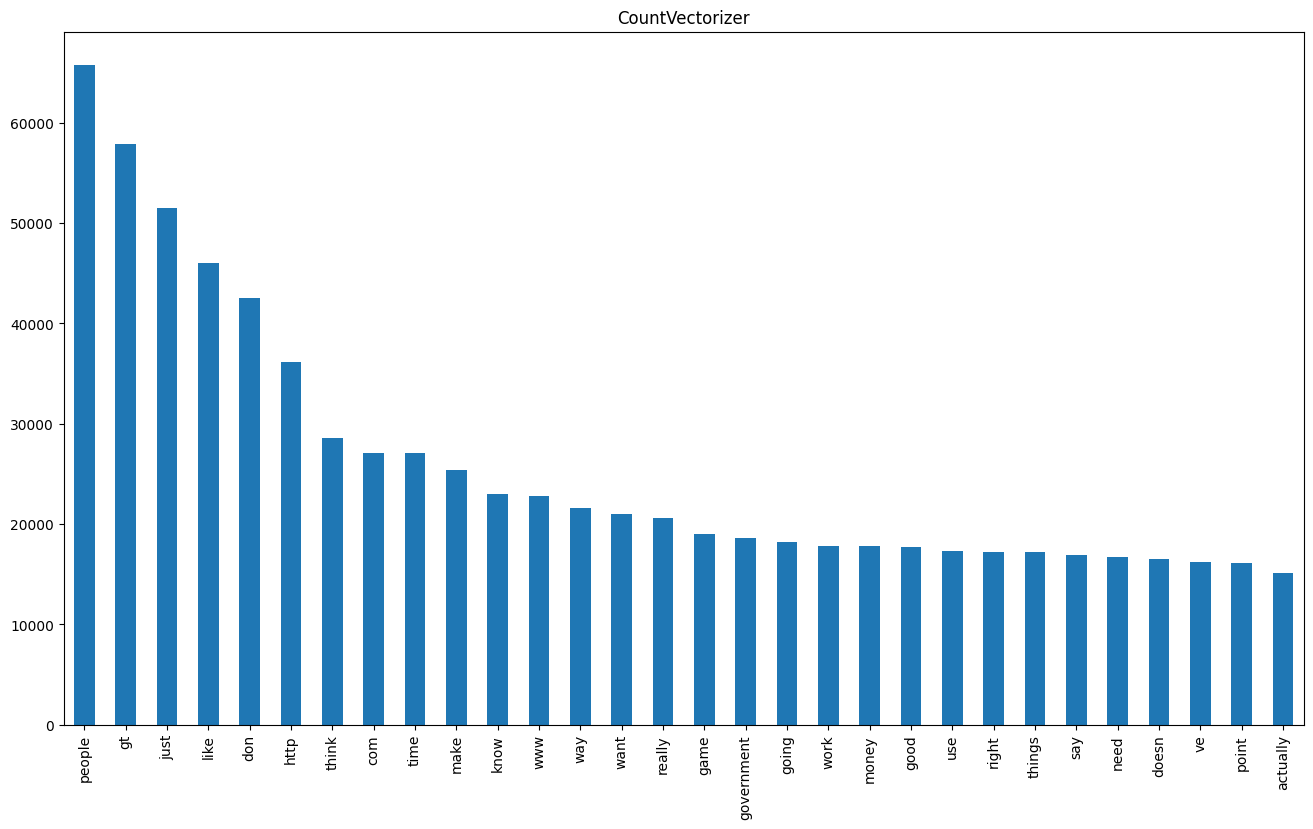

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

vectorizer = CountVectorizer(stop_words='english')

def plot_top_words(vectorizer: CountVectorizer, data: str):
    X = vectorizer.fit_transform(data)
    words = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    freq_distribution = pd.Series(counts, index=words)
    plt.figure(figsize=(16, 9))
    freq_distribution.sort_values(ascending=False).head(30).plot(kind='bar')
    plt.title(vectorizer.__class__.__name__)
    plt.show()

plot_top_words(vectorizer, df['body'])

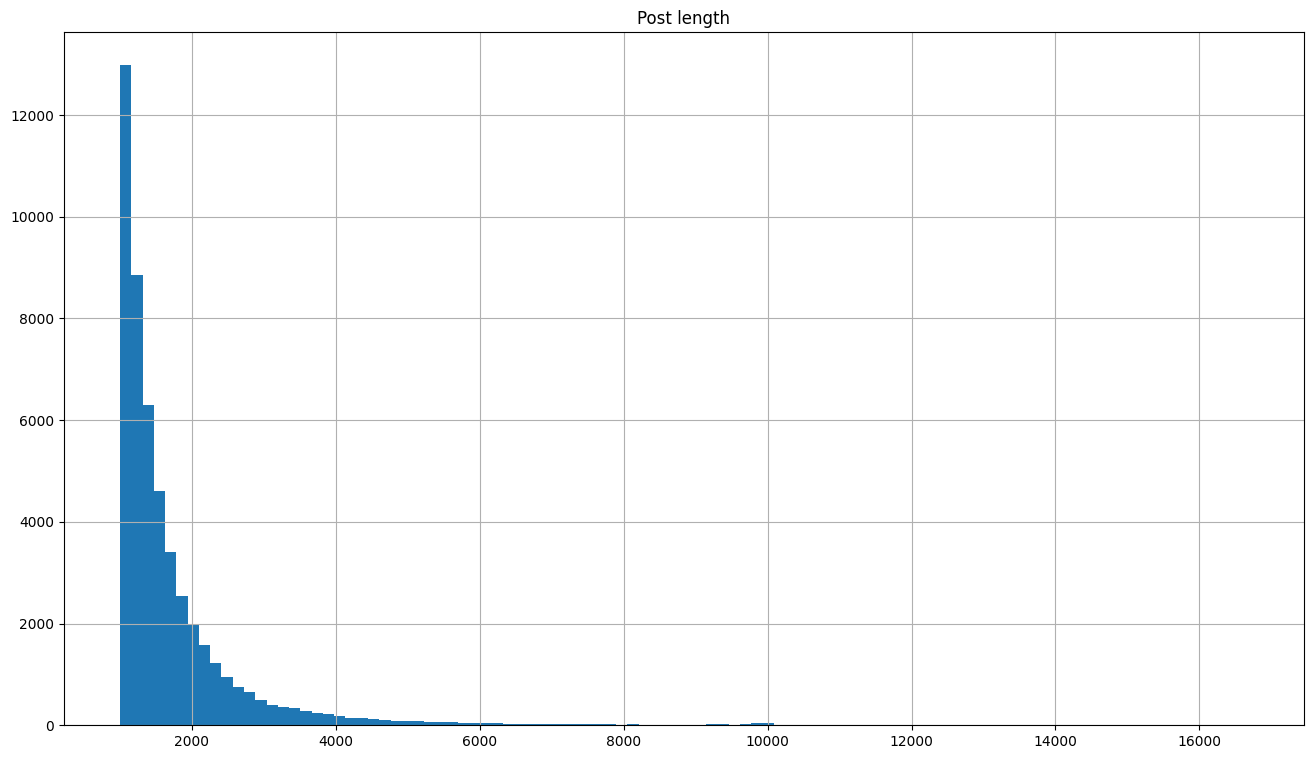

In [5]:
plt.figure(figsize=(16, 9))
df['body'].apply(len).hist(bins=100)
plt.title('Post length')
plt.show()

Detect language of the post, remove other than english

In [6]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

def detect_language(row):
    try:
        return detect(row['body'])
    except:
        return 'error'
    
df['language'] = df.apply(detect_language, axis=1)
df['language'].value_counts()

language
en       49813
error       82
de          28
pt           9
ca           8
fr           7
nl           7
tr           5
hu           4
pl           4
so           4
sw           3
it           3
uk           3
ru           2
ja           2
vi           2
sv           2
da           2
fi           1
af           1
fa           1
tl           1
sl           1
no           1
ar           1
es           1
lt           1
et           1
Name: count, dtype: int64

In [7]:
df = df[df['language'] == 'en']
df.shape

(49813, 20)

In [8]:
df['subreddit'].value_counts()

subreddit
politics       23506
technology      9566
gaming          9166
science         5167
programming     2408
Name: count, dtype: int64

In [9]:
df.to_pickle('filtered_en.pkl')

In [10]:
df = pd.read_pickle('filtered_en.pkl')

In [11]:
df['body'].iloc[0]

'I just started an account yesterday and only lurked for a day prior, ever.  I am perhaps not prototypical of the Grommet; I, of course, had heard of Reddit for years but indeed did dismiss it (for ego\'s sake apparently) for many of the reasons that have been posted here by veterans who appear to be holding on for dear life but holding on to the inevitable "we were here first, you don\'t know what we\'ve been through and seen man!" [meme if there ever was one]  I get it.  You know what actually made me create an account?  I was unabashedly blown away by the thought that went into the comments: thoughtful, brilliant and most importantly filled with genius  humor and poorly veiled caring. Ever watch Dead Wood? Yeah, like that. There is an added culpability and humility (mostly) that comes ONLY with actually caring for the art of language, timing and doing this without the hope of any gain except to communicate. (I\'ve still yet to delve into meaning of Gold, Karma and the proliferation 

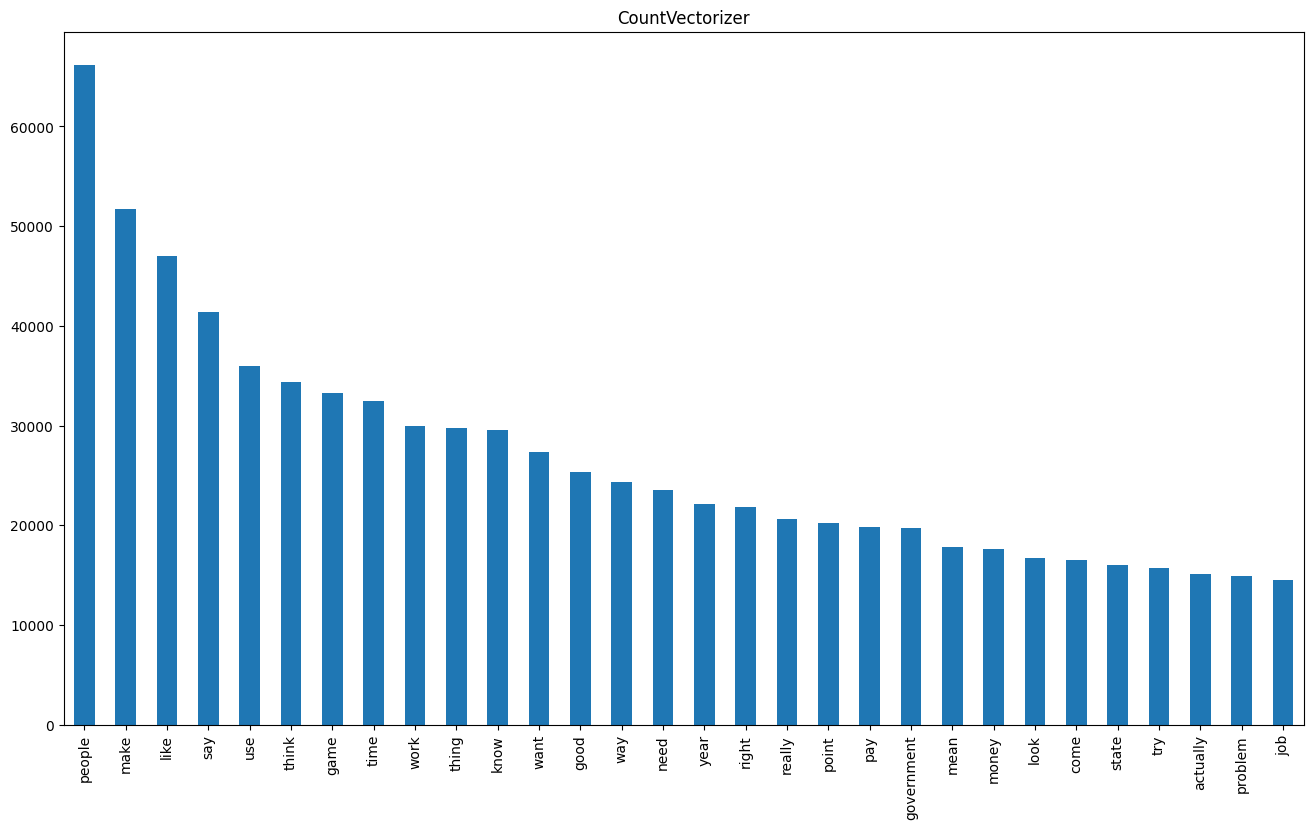

In [12]:
import re
from html import unescape
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer


def preprocessing(text: str,
              stop_words: list = stopwords.words('english'),
              lemmatizer: WordNetLemmatizer = WordNetLemmatizer(),
              pos_dict={'NOUN': 'n', 'VERB': 'v', 'ADJ': 'a', 'ADV': 'r'}) -> str:
    # Initial cleaning: lowercase, remove URLs, unescape HTML entities
    text = unescape(re.sub(r"http(s?)://\S+", '', text.lower()))

    # Remove stop words - first run
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    tokens = nltk.pos_tag(tokens, tagset='universal')

    result = []
    for token, pos in tokens:
        if token in stop_words:
            # Remove stop words - second run
            # Tokenization may reveal stop words, which were not removed in the first run
            continue
        pos = pos_dict.get(pos, 'n')

        # Lemmatize the token
        token = lemmatizer.lemmatize(token, pos)

        # Remove non-alphabetic characters
        token = re.sub(r"[^a-z]", ' ', token).strip()
        if token:
            result.append(token)

    # Remove stop words - third run
    # Replacing non-alphabetic characters may produce stop words: `he's` is not a stop word but `he` and `s` are
    return ' '.join([word for word in result if word not in stop_words])

# Lemmatize the text
df['body'] = df['body'].apply(preprocessing)

vectorizer = CountVectorizer(stop_words='english')
plot_top_words(vectorizer, df['body'])

In [13]:
df['body'].iloc[0]

'start account yesterday lurk day prior ever perhaps prototypical grommet course hear reddit year indeed dismiss ego sake apparently many reason post veteran appear hold dear life hold inevitable first know see man meme ever one get know actually make create account unabashedly blown away think go comment thoughtful brilliant importantly fill genius humor poorly veil caring ever watch dead wood yeah like add culpability humility mostly come actually caring art language time without hope gain except communicate still yet delve mean gold karma proliferation initialisms brilliant people read beautiful thing past hour without even remember initial subject read comment post prove fine cup whiskey easy thing say thank thank old timer put year yet still grumpy enough comment grumpiness thank youngster afraid edit thank make old man another grin faith holy shit people still interest edit'

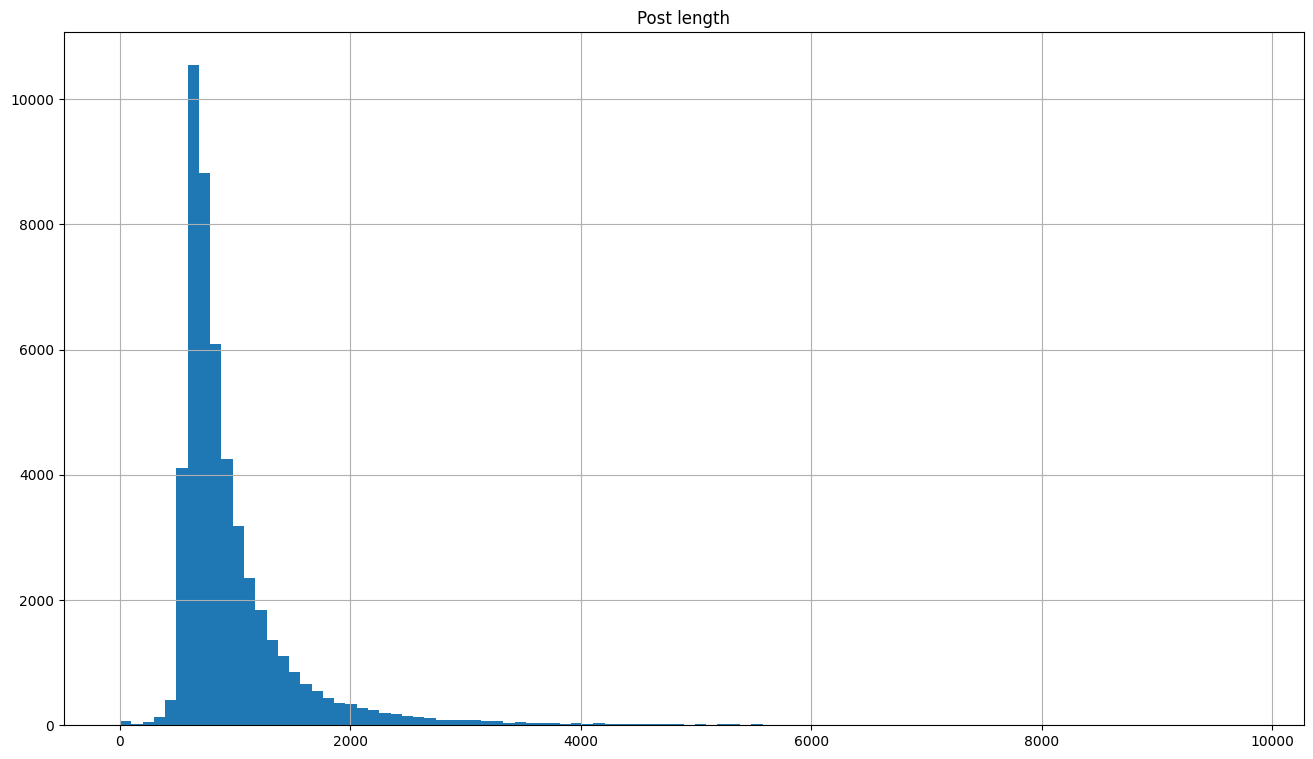

In [14]:
plt.figure(figsize=(16, 9))
df['body'].apply(len).hist(bins=100)
plt.title('Post length')
plt.show()

Now we have beautifully simplified text ❤️

## Feature generation

BBOW, BOW, *tf-idf*, words embeddings

### Bag of words

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X_bow = count_vectorizer.fit_transform(df['body'])
X_bow.shape

(49813, 90882)

### *tf-idf*

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
X_tfidf = tfidf.fit_transform(df['body'])
X_tfidf.shape

(49813, 90882)

## Model training

### Prepare numeric labels

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['y'] = le.fit_transform(df['subreddit'])

### Regression

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['y'], test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Results analysis

In [19]:
for i in range(10):
    print(le.classes_[y_test.iloc[i]], '->', le.classes_[y_pred[i]])

gaming -> gaming
technology -> technology
gaming -> gaming
politics -> technology
politics -> politics
politics -> politics
politics -> politics
politics -> politics
technology -> technology
science -> gaming


In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8256549232158988

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      gaming       0.92      0.84      0.88      1928
    politics       0.83      0.93      0.88      4691
 programming       0.87      0.67      0.75       467
     science       0.76      0.71      0.73      1011
  technology       0.74      0.65      0.69      1866

    accuracy                           0.83      9963
   macro avg       0.82      0.76      0.79      9963
weighted avg       0.83      0.83      0.82      9963



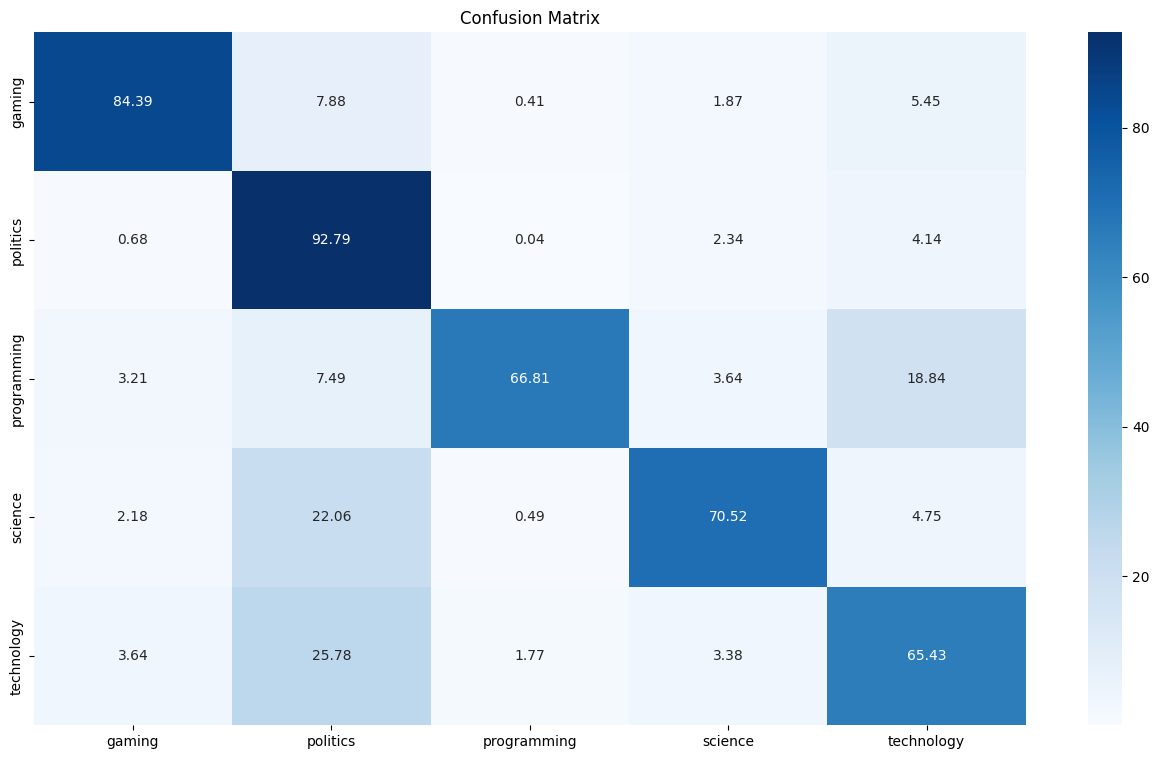

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(16, 9))
sns.heatmap(cm*100, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()